### Napari unwarper - auto alignment

In [2]:
import napari
from tifffile import imread
import numpy as np

from pointpats import PointPattern
import matplotlib.pyplot as plt

In [2]:
original_tif = '/Users/hotte/Downloads/AVG_FOV_256_zoom11test_AfterFixPCB_00001.tif'
original_tif_ = imread(original_tif)
print(original_tif_.shape)

(256, 256)


In [3]:
viewer = napari.view_image(original_tif_, rgb=False, name='Grid image')
grid_image_layer = viewer.layers['Grid image']

In [4]:
grid_image_layer.gamma = 1

In [5]:
viewer.add_points(name='Original', 
                  edge_width=1, 
                  edge_color='orangered',  
                  face_color = 'white',
                  opacity = .5,    
                  size=8,
                  blending='translucent'
              )
viewer.layers['Original'].mode ='add'
viewer.layers['Original'].symbol ='x'

In [6]:
layer_original = viewer.layers['Original']
usr_points = layer_original.data

In [108]:
#usr_points = usr_points[:,::-1]

In [109]:
len(usr_points)

89

In [110]:
first_points

array([[ 35.82963435,  -0.38914885],
       [253.25132211,  17.03944336]])

In [111]:
usr_point_pat = PointPattern(usr_points)

In [112]:
nn4, nnd4 = usr_point_pat.knn(4)

In [113]:
nnd_1 = nnd4[:,0]
med_dist = np.median(nnd_1)

print(f'Median spacing points: {med_dist:.2f}')
#plt.hist(nnd_1, bins=20);
#plt.axvline(np.median(nnd_1), color='k', ls=':')

Median spacing points: 23.01


In [114]:
angles = []
for no, (nn, nnd) in enumerate(zip(nn4, nnd4)): 
    filt = nn[nnd < med_dist * 1.5]
    

    for filt_idx in filt: 
        angle = np.arctan2(np.diff([usr_points[no][0], usr_points[filt_idx][0]]),
                           np.diff([usr_points[no][1], usr_points[filt_idx][1]]))[0]
        angles.append(angle)
angles = np.degrees(angles)

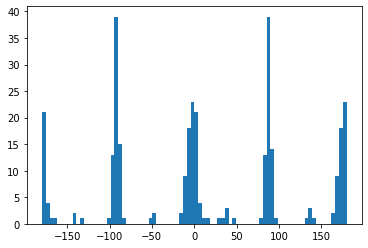

In [115]:
plt.hist(angles, bins=80);

In [116]:
from scipy import stats
from scipy.signal import find_peaks

In [117]:
x = angles
bins = np.arange(-180,180,1)

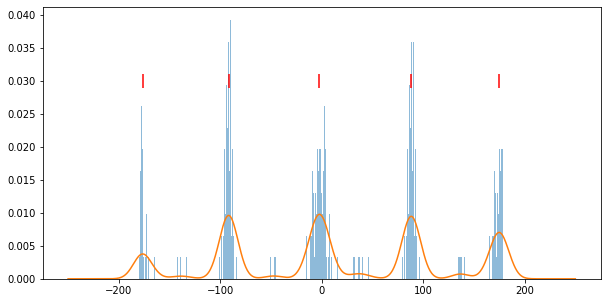

In [118]:
kde = stats.gaussian_kde(x , bw_method=.08)
xx = np.linspace(-250, 250, 1000)
figure = plt.figure(figsize=(10,5))
ax = figure.add_subplot(111)
ax.hist(x, density=True, bins=bins, alpha=0.5)
ax.plot(xx, kde(xx))

peaks = find_peaks(kde(xx), width=20, prominence=.001)
ax.scatter(xx[peaks[0]], np.zeros_like(peaks[0])+0.03, s=200, marker='|', color='red')

In [119]:
filt_peaks = [] 
for peak in np.mod(xx[peaks[0]],90):
    if np.abs(90-np.abs(peak)) < np.abs(peak):
        filt_peaks.append(90-np.abs(peak))
    else:
        filt_peaks.append(np.abs(peak))

In [120]:
print(f'Median orientation in degrees: {np.median(filt_peaks):.2}')

Median orientation in degrees: 2.3


In [124]:
# adapted from 
# https://stackoverflow.com/questions/29630052/ordering-coordinates-from-top-left-to-bottom-right/64659569#64659569

points = []
line_locations= []
keypoints_to_search = usr_points[:]
while len(keypoints_to_search) > 0:
    a = sorted(keypoints_to_search, key=lambda p: p[1] + p[0])[0]   # find upper left point
    b = sorted(keypoints_to_search, key=lambda p: p[0] - p[1])[-1]  # find bottom left point
    line_locations.append([[a[0], a[1]], [b[0], b[1]]])

    # convert to numpy 3d point
    a = np.array([a[1], a[0]])
    b = np.array([b[1], b[0]])

    row_points = []
    remaining_points = []
    dists = []
    for k in keypoints_to_search:
        p = np.array([k[1], k[0]])
        dist = np.linalg.norm(np.cross(np.subtract(p, a), np.subtract(b, a))) / np.linalg.norm(b)   # distance between keypoint and line a->b
        dists.append(dist)
        if dist < med_dist/2:
            row_points.append(k)
        else:
            remaining_points.append(k)
    print((len(row_points)))
    points.extend(sorted(row_points, key=lambda h: h[0]))
    keypoints_to_search = remaining_points
    break

9


In [125]:
viewer.add_shapes(np.asarray(line_locations), 
                  name ='Row lines',
                  shape_type='line', 
                  face_color = [0]*4, 
                  edge_color = "mediumturquoise", 
                  edge_width = .5)


<Shapes layer 'Row lines' at 0x7feddc990fd0>

In [135]:
def dist(pointA, pointB):
    dist = np.sqrt(np.square(pointB[0]-pointA[0]) + np.square(pointB[1]-pointA[1]))
    return dist

In [136]:
line_locations

[[[35.82963435435985, -1.6962932644661493],
  [253.68703691776457, 17.03944335598665]]]

In [137]:
points

[array([35.82963435, -1.69629326]),
 array([68.72449092,  1.01235233]),
 array([91.46056014,  4.47498106]),
 array([113.27698916,   7.71796376]),
 array([140.69493374,  10.07649662]),
 array([165.7691027 ,  12.98430055]),
 array([188.78041128,  14.14709728]),
 array([215.77984887,  14.42515453]),
 array([253.68703692,  17.03944336])]

In [142]:
start_point_line = points[0]
end_point_line   = points[-1]

In [140]:
med_dist

23.012697820240746

In [128]:
dist = np.sqrt(np.square(x2 - x1) + np.square(y2 - y1) )


NameError: name 'x2' is not defined

In [123]:
properties = {
    'point_idx': np.arange(len(points)),
}

viewer.add_points(name='Sorted points',
                  data=points,
                  text= {
                                'text': '{point_idx}',
                                'size': 12,
                                'weight':'bold',
                                'color': 'mediumseagreen',
                                'translation': np.array([-5, -5]),
                            },
                  properties=properties,
                  edge_width=1, 
                  edge_color='#000000',  
                  face_color = 'white',
                  opacity = .8,    
                  size=3,
                  blending='translucent'
              )

<Points layer 'Sorted points' at 0x7feddc8af550>